In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
from torchsummary import summary
from tqdm import tqdm
from torch.cuda.amp.grad_scaler import GradScaler


import matplotlib.pyplot as plt
import numpy as np
import os
import math
import cv2
from sklearn.metrics import ConfusionMatrixDisplay as CMD
from sklearn.metrics import confusion_matrix as CMT
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [ ]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pkbar
import pkbar

!pip install torchviz
from torchviz import make_dot

  Created wheel for torchviz: filename=torchviz-0.0.2-cp37-none-any.whl size=4152 sha256=fedd79f8084fa9043af56022037e72b83d223b666cb34cc7178e699b23d558f5
  Stored in directory: /root/.cache/pip/wheels/01/26/58/026ffd533dbe8b3972eb423da9c7949beca68d1c98ed9e8624
Successfully built torchviz


In [ ]:
batch_size= 8
device = 'cpu'
num_classes= 4
input_shape=(3,224,224)
learning_rate=1e-4
num_epochs= 50
size_parameter= 128
scaler= GradScaler()

/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:116: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


In [ ]:
main_path= 'drive/My Drive/Hist_folder/KMC Dataset'
train_dir= os.path.join(main_path,'Training')
test_dir= os.path.join(main_path,'Test')
val_dir= os.path.join(main_path,'Validation')

model_no= 2
name= 'Modified_LiverNet-3_' + str(size_parameter) + '_'+ str(model_no) +'.pth.tar'
check_pt_file= os.path.join(main_path, name)

print(check_pt_file)
print(os.listdir(test_dir))

drive/My Drive/Hist_folder/KMC Dataset/Modified_LiverNet-3_128_2.pth.tar
['grade1', 'grade0', 'grade2', 'grade3']


In [ ]:
my_transforms = transforms.Compose([ #Compose makes it possible to have many transforms
    transforms.ColorJitter(brightness=0.3, contrast=0.3), # Change brightness of image
    transforms.RandomRotation(degrees=60), # Perhaps a random rotation from -45 to 45 degrees
    transforms.RandomHorizontalFlip(p=0.5), # Flips the image horizontally with probability 0.5
    transforms.RandomVerticalFlip(p=0.05), # Flips image vertically with probability 0.05
    transforms.ToTensor() # Finally converts PIL image to tensor so we can train w. pytorch
    ])


In [ ]:
train_data= datasets.ImageFolder(train_dir, transform= my_transforms)
test_data= datasets.ImageFolder(test_dir, transform= transforms.ToTensor())
val_data= datasets.ImageFolder(val_dir, transform= transforms.ToTensor())

In [ ]:
train_loader= DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader= DataLoader(test_data, batch_size=batch_size, shuffle=True)
val_loader= DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [ ]:
class_dict=train_data.class_to_idx
class_labels = class_dict.values()
print(class_labels)

dict_values([0, 1, 2, 3])


### Plotting the images with classes



In [ ]:
# iterator= iter(train_loader)
# it= next(iterator)
# images, labels= it

# plt.figure(figsize=(20,15))
# for r in range(batch_size):
#     plt.subplot(4,8,r+1)
#     f= plt.imshow(images[r].permute(2,1,0))
#     plt.title(labels[r].item())
# plt.show()

#### Comparision Between Separable Convolutions and Straight Forward Convolution

In [ ]:
class Separable_Conv_Block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1):
        super(Separable_Conv_Block, self).__init__()
        self.depth_wise_conv = nn.Conv2d(in_channels, in_channels, kernel_size, stride=stride, padding=padding, dilation=dilation, groups=in_channels)
        self.point_wise_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0.1)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.depth_wise_conv(x)
        x = self.point_wise_conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

In [ ]:
class Conv_Block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1):
        super(Conv_Block, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0.1)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

In [ ]:
class Residual_Block(nn.Module):
  def __init__(self, in_channels, out_channels, identity_downsample= None, stride=1):
    super(Residual_Block,self).__init__()
    self.expn= 1
    self.conv1= Separable_Conv_Block(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0)
    self.bn1= nn.BatchNorm2d(num_features=out_channels)

    self.conv2= Separable_Conv_Block(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1)
    self.bn2= nn.BatchNorm2d(num_features=out_channels)

    self.conv3= Separable_Conv_Block(in_channels= out_channels, out_channels=out_channels*self.expn, kernel_size=1, stride=1, padding=0)
    self.bn3= nn.BatchNorm2d(num_features=out_channels*self.expn)
    self.relu= nn.ReLU()
    self.identity_downsample= identity_downsample

  def forward(self,x):

    identity=x
    x= nn.Sequential(self.conv1,
                     self.bn1,
                     self.conv2,
                     self.bn2,
                     self.conv3,
                     self.bn3)(x)
    if self.identity_downsample is not None:
      identity= self.identity_downsample(identity)
    
    x+= identity
    x=self.relu(x)
    
    return x

In [ ]:
class Classifier(nn.Module):
  def __init__(self, in_features, num_classes):
    super(Classifier, self).__init__()

    self.fc1=  nn.Sequential( nn.Linear(in_features, 256),
                              nn.BatchNorm1d(256),
                              nn.ReLU(),
                              nn.Dropout(p=0.3)
                            )
    self.fc2= nn.Linear(256, num_classes)
  
  def forward(self, x):
    x= x.reshape(x.shape[0],-1)
    return self.fc2(self.fc1(x))

In [ ]:
class CBAM_Block(nn.Module):

  def __init__(self, in_features):
    super(CBAM_Block, self).__init__()

    self.avgpool= nn.AdaptiveAvgPool2d((1,1))
    self.maxpool= nn.AdaptiveMaxPool2d((1,1))
    self.fc= nn.Linear(in_features, in_features)
    self.conv= Separable_Conv_Block(in_channels=2*in_features, out_channels=1, kernel_size=3, padding=1)
    self.act= nn.Sigmoid()
  
  def forward(self, x):

    A1= self.avgpool(x)
    A1= A1.reshape(A1.shape[0], -1)
    A2= self.maxpool(x)
    A2= A2.reshape(A2.shape[0], -1)
    Ac= self.act(self.fc(A1))+self.fc(A2)
    Ac= torch.unsqueeze(torch.unsqueeze(Ac, 2), 3)*x

    concat= torch.cat((self.avgpool(Ac), self.maxpool(Ac)), dim=1)
    As= self.act(self.conv(concat))*Ac
    return As

In [ ]:
class Modified_ASPP_Block(nn.Module):
  
  def __init__(self, in_channels, out_channels):
    super(Modified_ASPP_Block, self).__init__()

    self.conv_0= Separable_Conv_Block(in_channels, out_channels//4, kernel_size=3, padding=6, dilation=6)
    self.conv_1= Separable_Conv_Block(in_channels, out_channels//4, kernel_size=3, padding=6, dilation=6)

    self.conv_00= Separable_Conv_Block(out_channels//4, out_channels, kernel_size=5, padding=6, dilation=3)
    self.conv_01= Separable_Conv_Block(out_channels//4, out_channels, kernel_size=5, padding=6, dilation=3)
    self.conv_10= Separable_Conv_Block(out_channels//4, out_channels, kernel_size=5, padding=6, dilation=3)
    self.conv_11= Separable_Conv_Block(out_channels//4, out_channels, kernel_size=5, padding=6, dilation=3)

    self.conv_add= Separable_Conv_Block(in_channels, out_channels*4, kernel_size=1)
  def forward(self, x):

    x_0= self.conv_0(x)
    x_1= self.conv_1(x)
    x_00= self.conv_00(x_0)
    x_01= self.conv_01(x_0)
    x_10= self.conv_10(x_1)
    x_11= self.conv_11(x_1)

    return torch.cat((x_00, x_01, x_10, x_11), dim=1) + self.conv_add(x)

In [ ]:
class LiverNet(nn.Module):

  def __init__(self, image_shape, num_classes, size_parameter):
    super(LiverNet, self).__init__()

    self.aspp_out_channels= size_parameter
    self.conv_block_1= Separable_Conv_Block(3, 32, kernel_size=3, padding=1)
    self.conv_block_2= Separable_Conv_Block(32, 32, kernel_size=3, padding=1)
    self.pool= nn.MaxPool2d(kernel_size=2, stride=2)
    self.global_avg_pool= nn.AdaptiveAvgPool2d((1,1))
    self.conv_block_3= Separable_Conv_Block(32, 64, kernel_size=3, padding=1)
    self.cbam= CBAM_Block(in_features=64)
    self.res_block= Residual_Block(in_channels=64,
                                     out_channels=64,
                                     identity_downsample= Separable_Conv_Block(64, 64, kernel_size=1))
    self.conv_block_4= Separable_Conv_Block(64, 64, kernel_size=3, padding=1)

    self.aspp_1= Modified_ASPP_Block(in_channels=32, out_channels=self.aspp_out_channels)
    self.aspp_2= Modified_ASPP_Block(in_channels=64, out_channels=self.aspp_out_channels)
    self.upsample_1= nn.UpsamplingBilinear2d(scale_factor=2)
    self.upsample_2= nn.UpsamplingBilinear2d(scale_factor=4)
    self.upsample_3= nn.UpsamplingBilinear2d(scale_factor=8)
    self.classifier= Classifier(in_features=self.aspp_out_channels*12, num_classes=num_classes)

    
  def forward(self, x):

    x1= self.conv_block_1(x)
    x1= self.conv_block_2(x1)
    x1 = self.pool(x1)

    x2= self.conv_block_3(x1)
    x2= self.cbam(x2)
    x2= self.res_block(x2)
    x2= self.pool(x2)

    x3= self.conv_block_4(x2)
    x3= self.cbam(x3)
    x3= self.res_block(x3)
    x3= self.pool(x3)

    a1= self.aspp_1(x1)
    a1= self.upsample_1(a1)

    a2= self.aspp_2(x2)
    a2= self.upsample_2(a2)

    a3= self.aspp_2(x3)
    a3= self.upsample_3(a3)

    out= torch.cat((a1,a2,a3), dim=1)
    out= self.global_avg_pool(out)
    out= self.classifier(out)

    return out

In [ ]:
model= LiverNet(input_shape, num_classes, size_parameter).to(device)
summary(model, input_size= input_shape, batch_size=batch_size, device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [8, 3, 224, 224]              30
            Conv2d-2          [8, 32, 224, 224]             128
       BatchNorm2d-3          [8, 32, 224, 224]              64
              ReLU-4          [8, 32, 224, 224]               0
Separable_Conv_Block-5          [8, 32, 224, 224]               0
            Conv2d-6          [8, 32, 224, 224]             320
            Conv2d-7          [8, 32, 224, 224]           1,056
       BatchNorm2d-8          [8, 32, 224, 224]              64
              ReLU-9          [8, 32, 224, 224]               0
Separable_Conv_Block-10          [8, 32, 224, 224]               0
        MaxPool2d-11          [8, 32, 112, 112]               0
           Conv2d-12          [8, 32, 112, 112]             320
           Conv2d-13          [8, 64, 112, 112]           2,112
      BatchNorm2d-14          [8, 

### Visualizing the Modified ASPP Block

In [ ]:
# aspp_block= Modified_ASPP_Block(in_channels=64, out_channels=128).to(device)
# x= torch.randn((8, 64, 224, 224), device=device)
# y= aspp_block(x)
# make_dot(y, params=dict(list(aspp_block.named_parameters()))).render("torchviz", format="png")
# image= plt.imread('torchviz.png')
# plt.figure(figsize=(20, 30))
# plt.imshow(image)

In [ ]:
Loss= nn.CrossEntropyLoss()
optimizer= optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def check_accuracy(scores, targets):

  num_correct=0
  num_samples=0
  _, predictions= scores.max(1)
  num_correct+= (predictions== targets).sum()
  num_samples= predictions.size(0)

  return num_correct/num_samples

In [ ]:
def save_checkpoint(model, optimizer, file_name):

  checkpoint= {'state_dict': model.state_dict(),
             'optimizer_dict': optimizer.state_dict()}
  torch.save(checkpoint,file_name)

def load_checkpoint(model, optimizer, file_name):
  check_pt= torch.load(file_name, map_location= torch.device(device))
  model.load_state_dict(check_pt['state_dict'])
  optimizer.load_state_dict(check_pt['optimizer_dict'])

  return model, optimizer

In [ ]:
### Training Loop

# model, _= load_checkpoint(model, optimizer, check_pt_file)
train_per_epoch= len(train_loader)
val_per_epoch= len(val_loader)
min_loss= math.inf


for epoch in range(num_epochs):
  train_losses=[]
### TRAINING

  kbar_train= pkbar.Kbar(target= train_per_epoch, epoch=epoch, num_epochs=num_epochs)

  train_loop= enumerate(train_loader)
  val_loop= enumerate(val_loader)
  for batch_idx, (data,targets) in train_loop:

    model.train()

    data= data.to(device=device)
    targets= targets.to(device=device)

    # FORWARD PROP

    scores= model(data)
    train_loss= Loss(scores, targets)
    train_losses.append(train_loss.item())

    # BACKWARD PROP
    optimizer.zero_grad()
    train_loss.backward()

    optimizer.step()

    train_acc= check_accuracy(scores,targets)

    kbar_train.update(batch_idx, values=[("loss", train_loss.item()), ("accuracy", train_acc.item())])

  kbar_train.update(train_per_epoch, values=None)
### VALIDATION

  kbar_val= pkbar.Kbar(target= val_per_epoch, epoch=epoch, num_epochs=num_epochs)


  for batch_idx, (data, targets) in val_loop:

    val_losses=[]
    model.eval()

    
    data= data.to(device=device)
    targets= targets.to(device=device)
    scores= model(data)
    val_loss= Loss(scores, targets)
    val_losses.append(val_loss.item())
    val_acc= check_accuracy(scores,targets)

    kbar_val.update(batch_idx, values=[("val_loss", val_loss.item()), ("val_accuracy", val_acc.item())])

  if np.mean(val_losses)<min_loss:
    min_loss= val_loss.item()
    print('\nImproved validation loss: {:.4f}'.format(val_loss.item()))
    print('Saving the model to {}\n'.format(check_pt_file))
    save_checkpoint(model, optimizer, check_pt_file)
    
  kbar_val.update(val_per_epoch, values=None)

Epoch: 1/50
331/331 [==============================] - 1012s 3s/step - loss: 1.1150 - accuracy: 0.5109
Epoch: 1/50
34/35 [============================>.] - ETA: 3s - val_loss: 1.3491 - val_accuracy: 0.4265
Improved validation loss: 1.3419
Saving the model to drive/My Drive/Hist_folder/KMC Dataset/Modified_LiverNet-3_128_2.pth.tar

35/35 [==============================] - 105s 3s/step - val_loss: 1.3491 - val_accuracy: 0.4265
Epoch: 2/50
331/331 [==============================] - 137s 413ms/step - loss: 0.8738 - accuracy: 0.6190
Epoch: 2/50
34/35 [============================>.] - ETA: 0s - val_loss: 0.9390 - val_accuracy: 0.5882
Improved validation loss: 0.3272
Saving the model to drive/My Drive/Hist_folder/KMC Dataset/Modified_LiverNet-3_128_2.pth.tar

35/35 [==============================] - 5s 154ms/step - val_loss: 0.9390 - val_accuracy: 0.5882
Epoch: 3/50
331/331 [==============================] - 137s 413ms/step - loss: 0.7464 - accuracy: 0.6802
Epoch: 3/50
35/35 [===============

In [ ]:
liver_net, _= load_checkpoint(model, optimizer, check_pt_file)

In [ ]:
def get_all_preds(model, loader):
    all_preds = torch.tensor([], device=device)
    all_labels= torch.tensor([], device=device)
    for images,labels in loader:
        images= images.to(device)
        labels= labels.to(device)
        scores = model(images)
        _, preds= scores.max(1)
        all_preds = torch.cat((all_preds, preds),dim=0)
        all_labels = torch.cat((all_labels, labels),dim=0)
    return all_preds, all_labels

with torch.no_grad():
    all_preds, all_labels = get_all_preds(liver_net.to(device), test_loader)


[0.9516129  0.74712644 0.78313253 0.875     ]
[0.84285714 0.8125     0.8125     0.84      ]
[0.89393939 0.77844311 0.79754601 0.85714286]
0.825


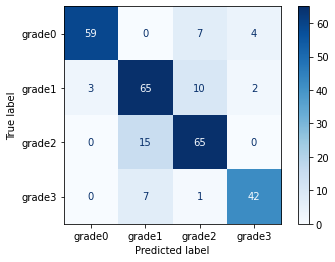

In [ ]:

cmt= CMT(all_labels.cpu(), all_preds.cpu())
prec, rec, f1,_= precision_recall_fscore_support(all_labels.cpu(), all_preds.cpu())
acc= accuracy_score(all_labels.cpu(), all_preds.cpu())
names= sorted(os.listdir(test_dir))
disp= CMD(cmt, names)
disp.plot(cmap='Blues')


print(prec)
print(rec)
print(f1)
print(acc)